In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm

Get data

In [3]:
img_path = "../data/Raw/"
img_width, img_height = 128, 128
batch_size = 128
datagen = ImageDataGenerator(
    rescale=1. / 255., 
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.3)
train_generator = datagen.flow_from_directory(img_path, 
                                    subset='training',
                                    target_size=(img_height, img_width), 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
valid_generator = datagen.flow_from_directory(img_path, 
                                    subset='validation',
                                    target_size=(img_height, img_width), 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')


Found 644 images belonging to 20 classes.
Found 263 images belonging to 20 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


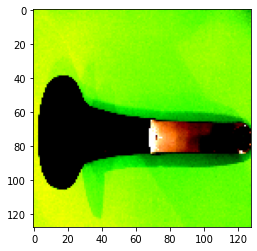

In [4]:
plt.imshow(train_generator[2][0][0])

In [5]:
class_num = train_generator.num_classes

Модель

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num))
model.add(Activation('softmax'))

In [7]:
epochs = 1
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
seed = 21
np.random.seed(seed)
model.fit(train_generator, validation_data=valid_generator, epochs=epochs)

6/6 [==============================] - 109s 21s/step - loss: 3.6513 - accuracy: 0.0776 - val_loss: 3.1156 - val_accuracy: 0.1103


Оценка качества

In [8]:
scores = model.evaluate(valid_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 11.03%


In [9]:
scores

[3.1156322956085205, 0.11026615649461746]